In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import os
import glob as gb
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPooling2D
from keras.callbacks import EarlyStopping
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle

In [25]:
train_path = '/content/drive/MyDrive/DR assignment 2/train'

test_path = '/content/drive/MyDrive/DR assignment 2/test'

In [26]:
image_size=224

In [27]:
if os.path.exists(train_path):
   print(f"Train data is located at {train_path}")
else:
   print(f"Train data is not located at {train_path}")


if os.path.exists(test_path):
   print(f"Test data is located at {test_path}")
else:
   print(f"Test data is not located at {test_path}")


Train data is located at /content/drive/MyDrive/DR assignment 2/train
Test data is located at /content/drive/MyDrive/DR assignment 2/test


In [28]:
for folder in os.listdir(train_path):
    files = gb.glob(pathname= str(train_path + '//' + folder + '/*.jpg')) #glob --> to search a specific file extension
    print(f'For training data , found {len(files)} in folder {folder}')

For training data , found 52 in folder Class (1)
For training data , found 52 in folder Class (2)


In [29]:
for folder in os.listdir(test_path):
    files = gb.glob(pathname= str(test_path + '//' + folder + '/*.jpg'))
    print(f'For test data , found {len(files)} in folder {folder}')

For test data , found 12 in folder Class (2)
For test data , found 12 in folder Class (1)


In [30]:

img_size = []
for folder in os.listdir(train_path):
    files = gb.glob(pathname= str(train_path + '//' + folder + '/*.jpg')) #For each folder, it uses the gb.glob() function to find all of the JPG files in the folder.

    for file in files:
        image = plt.imread(file) #For each JPG file, it loads the image using the plt.imread() function.
        img_size.append(image.shape)

pd.Series(img_size).value_counts() #It uses the value_counts() method to count the number of times each image size appears in the size Series.


(256, 256, 3)    104
dtype: int64

In [31]:
img_size = []
for folder in os.listdir(test_path):
    files = gb.glob(pathname= str(test_path + '//' + folder + '/*.jpg')) #For each folder, it uses the gb.glob() function to find all of the JPG files in the folder.

    for file in files:
        image = plt.imread(file) #For each JPG file, it loads the image using the plt.imread() function.
        img_size.append(image.shape)

pd.Series(img_size).value_counts() #It uses the value_counts() method to count the number of times each image size appears in the size Series.


(256, 256, 3)    24
dtype: int64

In [32]:
#convert from text to numeric
code = {'Class (1)':0 ,'Class (2)':1} #dictionary

#convert from numeric to  text
def getcode(n) :
    for x , y in code.items() :
        if n == y :
            return x

In [33]:
X_train = []
y_train= []

for folder in os.listdir(train_path):
    files = gb.glob(pathname=str(train_path + '//' + folder + '/*.jpg'))
    for file in tqdm(files):
        image = cv2.imread(file)
        image_array = cv2.resize(image, (image_size, image_size))
        X_train.append(list(image_array))
        y_train.append(code[folder])


100%|██████████| 52/52 [00:00<00:00, 378.37it/s]


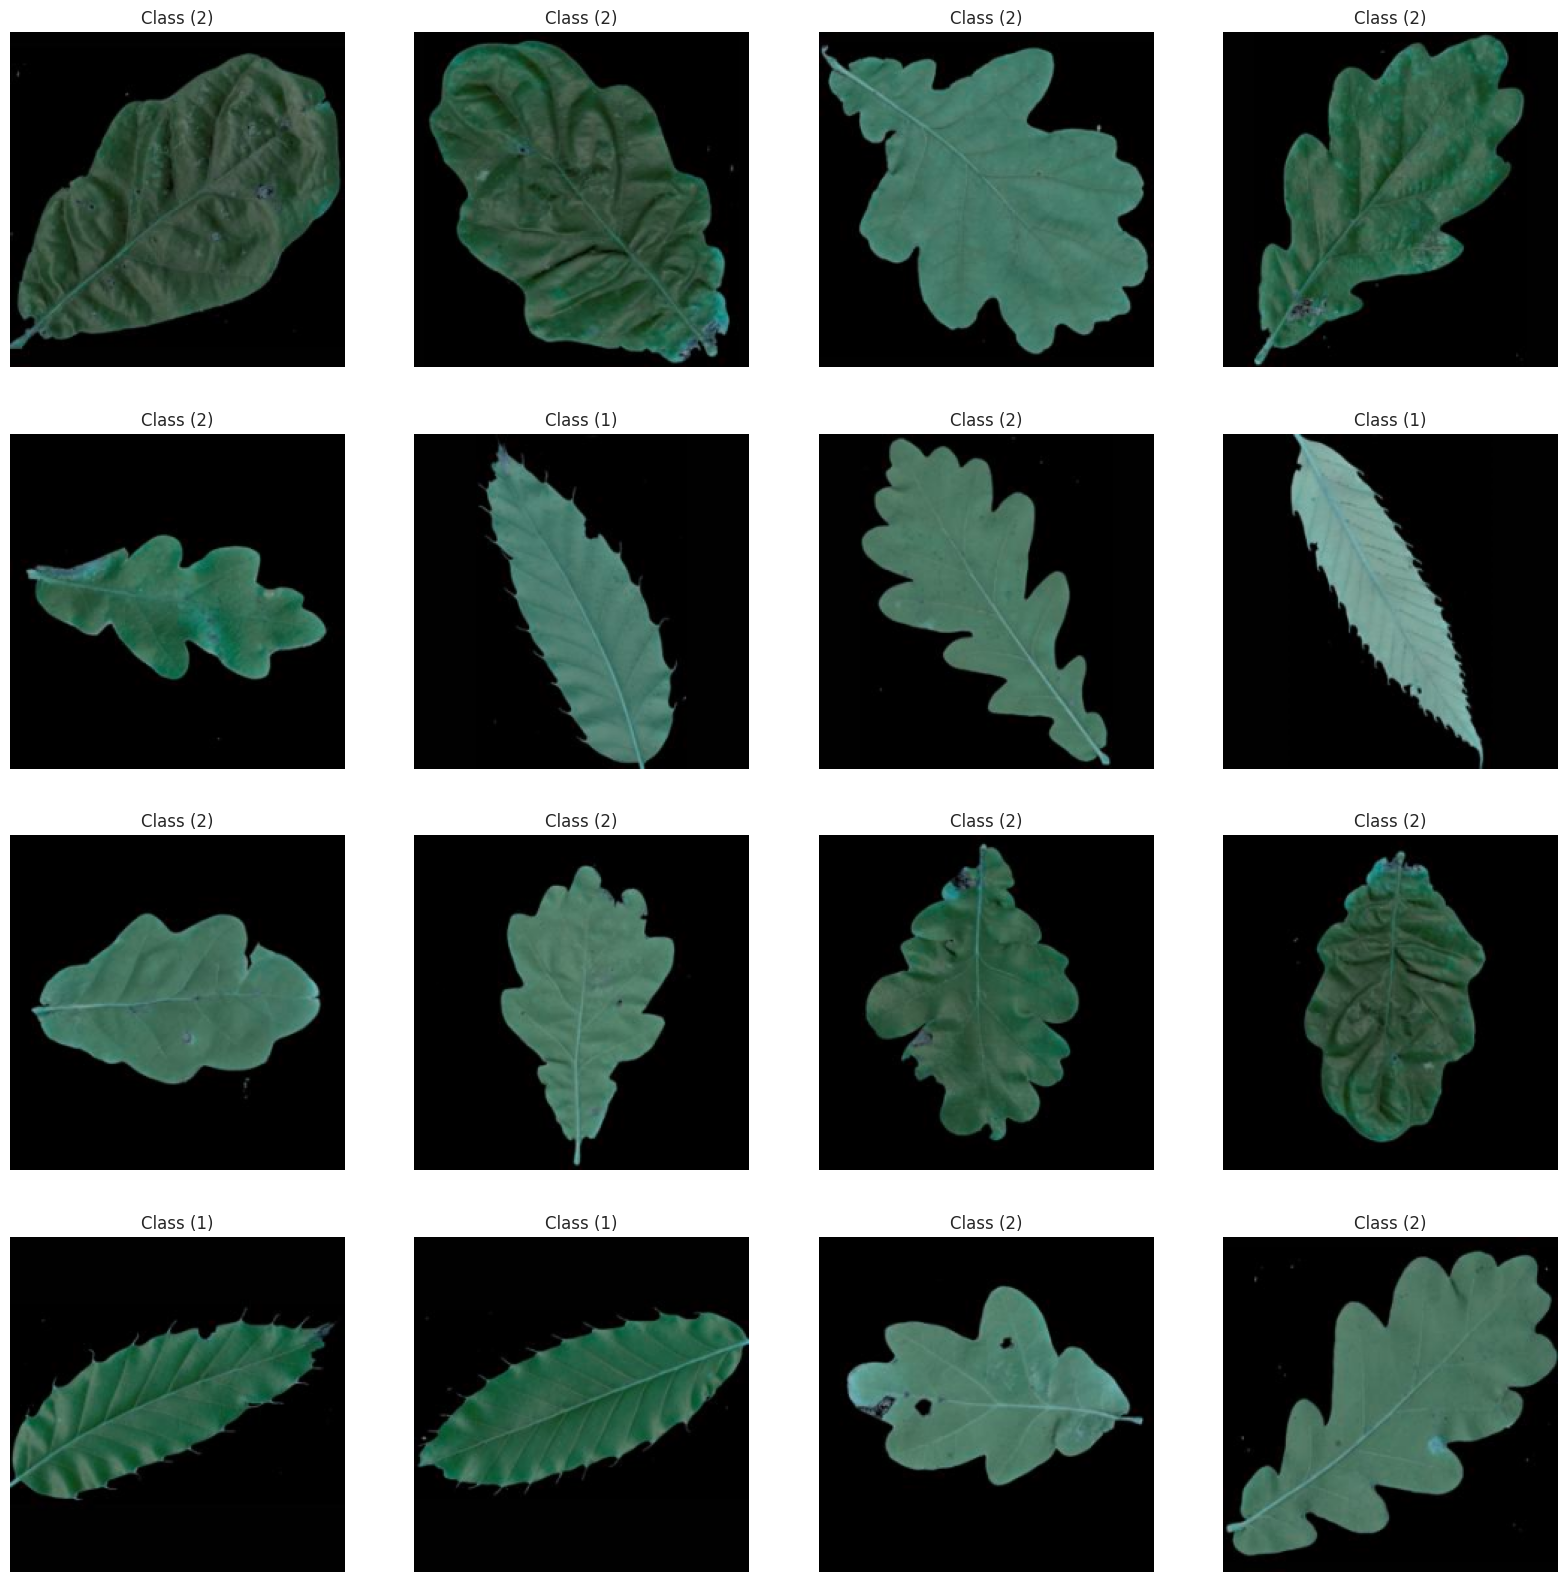

In [34]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_train),16))) :   #choose (16) random number from 0 t0 14034 #n-->index  , i-->value
    plt.subplot(4,4,n+1) # 4*4 =16 pictures
    plt.imshow(X_train[i])   #image show , picture is copressed by cv
    plt.axis('off')
    plt.title(getcode(y_train[i]))



In [35]:
X_test = []
y_test = []

for folder in  os.listdir(test_path) :
    files = gb.glob(pathname= str( test_path +'//' + folder + '/*.jpg'))
    for file in tqdm(files):
        image = cv2.imread(file)
        image_array = cv2.resize(image , (image_size,image_size))
        X_test.append(list(image_array))
        y_test.append(code[folder])

100%|██████████| 12/12 [00:00<00:00, 385.00it/s]


In [36]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)


In [37]:
print("Train dataset shape:\n")
print(f'X_train shape  is {X_train.shape}\n')
print(f'y_train shape  is {y_train.shape}\n')

print("Test dataset shape:\n")
print(f'X_test shape  is {X_test.shape}\n')
print(f'y_test shape  is {y_test.shape}\n')


Train dataset shape:

X_train shape  is (104, 224, 224, 3)

y_train shape  is (104,)

Test dataset shape:

X_test shape  is (24, 224, 224, 3)

y_test shape  is (24,)



In [38]:
X_train= X_train /255
X_test= X_test/255

In [39]:
repetition=5
def augment(dataset):
   augmented_images = []
   for image in dataset:
       image = np.expand_dims(image, axis=0)
       for _ in range(repetition):
           random_seed = np.random.randint(0, 1000)
           rotation_range = np.random.uniform(0, 20) # Randomly rotated by up to 20 degrees in either direction.
           width_shift_range = np.random.uniform(0, 0.2) # Randomly shift images horizontally (fraction of total width)
           height_shift_range = np.random.uniform(0, 0.2) # Randomly shift images vertically (fraction of total height)
           shear_range = np.random.uniform(0, 0.2) # Set range for random shear
           zoom_range = np.random.uniform(0, 0.2) # Set range for random zoom
           data_augmentation = ImageDataGenerator(
               rotation_range=rotation_range,
               width_shift_range=width_shift_range,
               height_shift_range=height_shift_range,
               shear_range=shear_range,
               zoom_range=zoom_range,
               horizontal_flip=True, # Randomly flip images
               fill_mode='nearest' # Set mode for filling points outside the input boundaries
           )
           for batch in data_augmentation.flow(image, batch_size=1, seed=random_seed):
               augmented_images.append(np.squeeze(batch))
               break
   return np.array(augmented_images)


X_train_augmented = augment(X_train)
y_train_augmented = np.repeat(y_train, repetition, axis=0)

X_test_augmented = augment(X_test)
y_test_augmented = np.repeat(y_test, repetition, axis=0)

In [40]:
# Merge original and augmented data
X_train_merged = np.append(X_train, X_train_augmented, axis=0)
y_train_merged = np.append(y_train, y_train_augmented, axis=0)

X_train_merged, y_train_merged = shuffle(X_train_merged, y_train_merged, random_state=42)

X_test_merged = np.append(X_test, X_test_augmented, axis=0)
y_test_merged = np.append(y_test, y_test_augmented, axis=0)

X_test_merged, y_test_merged = shuffle(X_test_merged, y_test_merged, random_state=42)


In [41]:
print("Train dataset shape:\n")
print(f'X_train shape  is {X_train_merged.shape}\n')
print(f'y_train shape  is {y_train_merged.shape}\n')

print("Test dataset shape:\n")
print(f'X_test shape  is {X_test_merged.shape}\n')
print(f'y_test shape  is {y_test_merged.shape}\n')


Train dataset shape:

X_train shape  is (624, 224, 224, 3)

y_train shape  is (624,)

Test dataset shape:

X_test shape  is (144, 224, 224, 3)

y_test shape  is (144,)



In [42]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2

vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3))

for layer in vgg19.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg19)

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

model.summary()


80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                         

In [43]:
#from keras.optimizers import Adam
# Compile the model
#Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
early_stopping_monitor = EarlyStopping(monitor='val_loss',patience=2)

# Fit the model to the training data
history=model.fit(X_train_merged ,y_train_merged,validation_split=0.3,epochs=15,callbacks=[early_stopping_monitor])

Epoch 1/15
14/14 [==============================] - 305s 22s/step - loss: 0.7073 - accuracy: 0.7179 - val_loss: 0.0443 - val_accuracy: 0.9894
Epoch 2/15
14/14 [==============================] - 310s 23s/step - loss: 0.1428 - accuracy: 0.9495 - val_loss: 0.0167 - val_accuracy: 0.9947
Epoch 3/15
14/14 [==============================] - 310s 23s/step - loss: 0.0721 - accuracy: 0.9702 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 4/15
14/14 [==============================] - 353s 26s/step - loss: 0.0260 - accuracy: 0.9931 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 5/15
14/14 [==============================] - 301s 22s/step - loss: 0.0092 - accuracy: 0.9977 - val_loss: 5.2345e-04 - val_accuracy: 1.0000
Epoch 6/15
14/14 [==============================] - 303s 22s/step - loss: 0.0125 - accuracy: 0.9954 - val_loss: 9.5405e-04 - val_accuracy: 1.0000
Epoch 7/15
14/14 [==============================] - 302s 22s/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 3.5337e-04 - val_accuracy: 1

In [45]:
Test_Loss, Test_Accuracy  = model.evaluate(X_test_merged , y_test_merged )

print('Test Loss is {}'.format(Test_Loss))
print('Test Accuracy is {}'.format(Test_Accuracy ))

5/5 [==============================] - 70s 14s/step - loss: 0.0073 - accuracy: 0.9931
Test Loss is 0.00727543979883194
Test Accuracy is 0.9930555820465088


In [46]:
y_pred = model.predict(X_test_merged)

5/5 [==============================] - 69s 13s/step


In [47]:
# select the indix with the maximum probability
y_pred = np.argmax(y_pred,axis = 1)

print(f'y_pred shape  is {y_pred.shape}')

y_pred shape  is (144,)


In [48]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
# Evaluate the model
accuracy = accuracy_score(y_test_merged, y_pred)
precision = precision_score(y_test_merged, y_pred)
recall = recall_score(y_test_merged, y_pred)
f1 = f1_score(y_test_merged, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1-score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


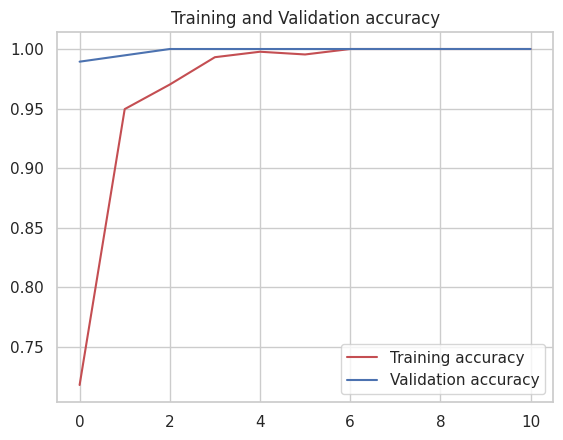

<Figure size 640x480 with 0 Axes>

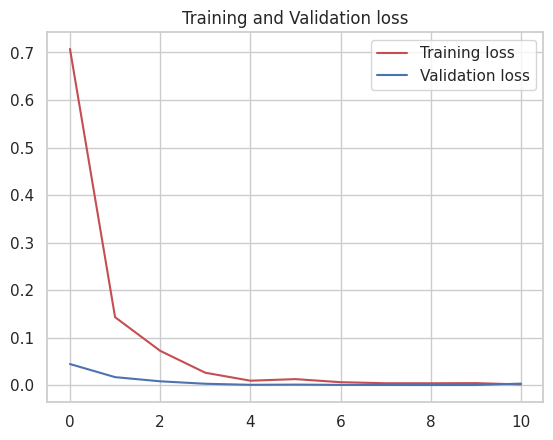

<Figure size 640x480 with 0 Axes>

In [49]:
# Plot the training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(len(training_accuracy))

plt.plot(epochs, training_accuracy, 'r', label="Training accuracy")
plt.plot(epochs, validation_accuracy, 'b', label="Validation accuracy")
plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

# Plot the training and validation loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(epochs, training_loss, 'r', label="Training loss")
plt.plot(epochs, validation_loss, 'b', label="Validation loss")
plt.title('Training and Validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()


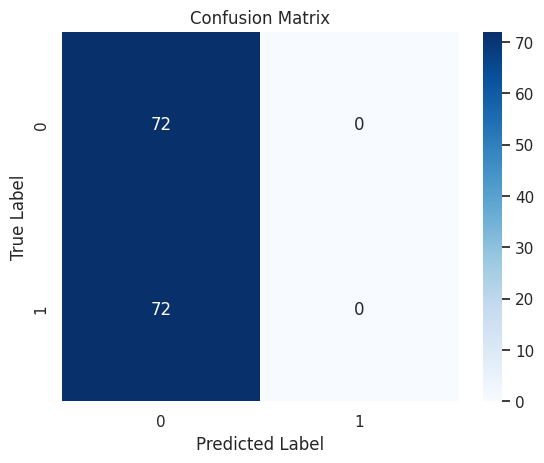

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(np.array(y_test_merged), np.array(y_pred))

# Plot the confusion matrix
ax = sns.heatmap(cm, annot=True, cmap="Blues")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.show()